Clustering tree morphologies via [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is pairwise bottleneck distances between persistence diagrams generated from neuronal morphologies.

See [Li Y, Wang D, Ascoli GA, Mitra P, Wang Y (2017) Metrics for comparing neuronal tree shapes based on persistent homology. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182184) for the general approach

In [1]:
import imagej
import time
import persim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
# Initialize Fiji with GUI support.
ij = imagej.init(r'C:\Users\cam\Desktop\My_Desktop\Fiji.app', headless=False)
from jnius import autoclass, cast

In [3]:
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')

In [4]:
diagram_map = {} # needs to be global

def run ():
    # Two types of mouse PT neuron with differing projection patterns descbried in 
    # Economo et al. Nature 2018
    # pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    group1 = ['AA1043', 'AA0180', 'AA0169', 'AA0134', 'AA0133', 'AA0131', 'AA0012']
    group2 = ['AA0899', 'AA0898', 'AA0863', 'AA0854', 'AA0839', 'AA0836', 'AA0835']
    groups = [group1, group2]
    
    trees = []
    cell_ids = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return 
            tree = loader.getTree()
            tree.setLabel(tree.getLabel() + "group {}".format(num))
            diagram = np.asarray(ij.py.from_java(PersistenceAnalyzer(tree).getPersistenceDiagram()))
            key = int(tree.getLabel()[2:6])
            diagram_map[key] = diagram
            cell_ids.append([key])
            trees.append(tree)

    t0 = time.time()
    matrix = get_distance_matrix(cell_ids)
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(affinity='precomputed', linkage='single', distance_threshold=0, n_clusters=None)

    # fit the model to the precomputed bottleneck distance matrix
    model = model.fit(matrix)
    plt.title('Hierarchical Clustering Dendrogram')

    plot_dendrogram(model, truncate_mode='level', p=10)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

def mydist(a1, a2):
    # bottleneck distance between two persistence diagrams
    return persim.bottleneck(diagram_map[a1[0]], diagram_map[a2[0]], matching=False)

def get_distance_matrix(cell_ids):
    # Note this is slow, for a more effecient approach use the persistence vectorization approach instead.
    # However, the bottleneck distance is the gold standard in terms of accuracy.
    M = pairwise_distances(cell_ids, metric=mydist)
    return M

# Hierarchical Clustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs) 

155.5521514415741  seconds to compute all distances


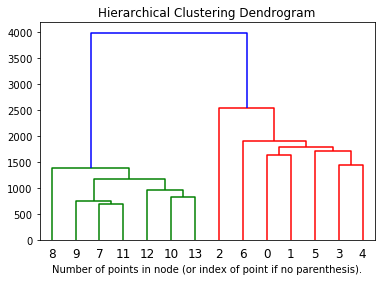

In [5]:
run()